## Questions

### Question 1

1) Elabore um programa que recebe na entrada um sinal amostrado com uma taxa conhecida. O programa deve gerar na saída uma imagem em que as colunas representam indíces de tempo de duração especificada e as linhas representam faixas de frequência com largura também especificada. Nesta imagem, em cada pixel tem-se um valor de cinza proporcional à energia do sinal naquela faixa de tempo, naquela banda de frequência.

![image](images/espectograma.png)

Usar a WFT (transformada janelada de Fourier)

### Question 2

2) Teste o seu programa com sinais do tipo "chirps" amostrados.

\begin{eqnarray}
x_c(t) = A \sin (2 \pi f(t) t)
\end{eqnarray}

com $f(t)$ conhecida. Por exemplo:

\begin{eqnarray}
f(t) = kt
\end{eqnarray}

### Question 3

3) Repita o exercício 1, porém partindo de uma decomposição QMF multinível dos sinais (o tipo de filtros é um parâmetro de entrada). Neste caso, a imagem final não será composta de retângulos de mesma área.

### Question 4

4) Cálculo de algumas características temporais e em frequência de sinais. Implementar um programa para o cálculo.

<font color='red'> * Para cada janela: </font>

**Entradas:** sinal, taxa de amostragem, largura da janela, tipo de janela, número de bandas para o caso da distribuição de energia.

**Saída:** valor médio retificado (médio do valor absoluto), valor eficaz (RMS: root mean square), desvio padrão.

<font color='green'> OBS: posteriormente para sinais de ECG: intervalo RR, intervalo RS, relação entre picos R e S etc. </font>

**Calcular:**

- Frequência modal
- Frequência média
- Frequência mediana
- Energia em cada banda

## Solutions

### Import libraries

In [19]:
from scipy.signal import hamming
from scipy.signal import chirp
from numpy.fft import fft
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import convolve as conv
%matplotlib notebook

### Functions

In [2]:
def plotSignal(signal, fs, t0=0, delta_t=-1, show_plot=True):
    """
    This function plots a signal for a given time interval.

    If no interval if given the whole signal will be plotted.

    If the interval exceeds the signal duration, 
    a warning will be printed in the terminal

    Parameters
    ----------
    signal : numpy array (signal_length,)
        The signal as a row vector
    fs : integer
        The signal sampling rate in Hertz
    t0 : float
        The time to begin plotting in seconds
    delta_t : float
        The duration of the signal to be plotted in seconds
    """
    if delta_t == -1: # if delta is -1 plot till the end of the signal
        # set delta to the duration of the signal minus t0
        delta_t = len(signal)*(1/fs) - t0 
    # calculate duration from num of samples and sampling rate
    duration = len(signal)*(1/fs) 
    # get input required duration
    calc_duration = t0 + delta_t 
    # check if required duration exceeds the real duration
    if calc_duration > duration: 
        print("Exceeded signal duration")
        return
    # get equivalent sample for the initial time
    n0 = int(round(t0*fs)) 
    # get equivalent sample for the final time
    n1 = n0 + int(round(delta_t*fs)) 
    # produce time vector to show plot in sec
    t = np.linspace(0, len(signal)/fs, len(signal))
    # configure plot for the signal
    if show_plot:
        plt.figure()
        plt.plot(t[n0:n1], signal[n0:n1])
        plt.ylabel("Signal amplitude")
        plt.xlabel("time (s)")
        plt.grid()
        plt.show()
    else:
        return t[n0:n1], signal[n0:n1]

In [3]:
def plotPSDSignal(signal, fs):
    """
    This function plots a signal power espectrum density (PSD)

    Parameters
    ----------
    esignal : numpy array (signal_length,)
        The signal as a row vector
    fs : integer
        The signal sampling rate in Hertz
    """
    N = len(signal) # store the number of sample in the signal
    # create a frequency vector to match the frequency index for each sample
    f = np.linspace(0, fs, N)
    # apply the fft transform to the signal normalized by the signal length
    signal_fft = np.fft.fft(signal)/N
    # calculate the PSB by elevating the signal magnitude to the second power
    psd = np.power(np.abs(signal_fft), 2)
    # configure plot
    plt.figure() 
    # plot only the positive frequencies
    plt.plot(f[:N // 2], psd[:N // 2])
    plt.xlabel("frequency (Hz)")
    plt.grid()
    plt.show()

In [4]:
def getEEGSignals(set_name = 'A', signal_number = 1):
    sig_str = str(signal_number)
    sig_num = sig_str.zfill(3)
    if set_name == 'A':
        data_path = '/home/victormacedo10/PSB/sinais_eeg/sinais/set' + set_name + '/Z' + sig_num + '.txt'
    if set_name == 'B':
        data_path = '/home/victormacedo10/PSB/sinais_eeg/sinais/set' + set_name + '/O' + sig_num + '.txt'
    if set_name == 'C':
        data_path = '/home/victormacedo10/PSB/sinais_eeg/sinais/set' + set_name + '/N' + sig_num + '.TXT' 
    if set_name == 'D':
        data_path = '/home/victormacedo10/PSB/sinais_eeg/sinais/set' + set_name + '/F' + sig_num + '.txt' 
    if set_name == 'E':
        data_path = '/home/victormacedo10/PSB/sinais_eeg/sinais/set' + set_name + '/S' + sig_num + '.txt' 
    data_output = np.loadtxt(data_path)
    print(data_path)
    return data_output

In [5]:
# Questão 1
def timeFrequencyVisualization(x, fs, window_duration_seconds, window_type=None, nfft=None, window_overlap=0.5):
    N_window = int(np.round(window_duration_seconds * fs))
    if nfft == None:
        nfft = N_window
    if window_type == None:
        window_type = lambda x: x
        window_type = hamming
    w = window_type(N_window)
    window_n1 = 0
    window_n2 = window_n1 + N_window - 1
    window_shift = np.round((1-window_overlap) * N_window).astype(int)
    s = np.zeros([np.round(nfft/2).astype(int), np.floor((len(x) - N_window)/window_shift + 1).astype(int)])
    s_sig = np.zeros([nfft, np.floor((len(x) - N_window)/window_shift + 1).astype(int)])
    number_windows = 0
    while(window_n2 <= len(x)):
        xw = x[window_n1 : window_n2+1] * w
        s_sig[:, number_windows] = x[window_n1 : window_n2+1]
        Xw = fft(xw, int(nfft))
        Xw = Xw[:int(np.floor(nfft/2))]
        Xw = np.power(np.abs(Xw), 2)
        s[:, number_windows] = Xw
        number_windows = number_windows + 1
        window_n1 = window_n1 + window_shift
        window_n2 = window_n2 + window_shift
    return s, s_sig

In [6]:
def plot_spectogram(matrix, t, fs):   
    f_map = np.linspace(0, fs/2, matrix.shape[0])
    t_map = np.linspace(min(t), max(t), matrix.shape[1])
    X, Y = np.meshgrid(t_map, f_map)
    fig, ax = plt.subplots(1, 1)
    ax.pcolormesh(X, Y, matrix)
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")

In [17]:
def downsample(x, factor):
    x = x[:len(x):factor]
    return x
def upsample(x, factor):
    y = np.zeros(len(x)*factor)
    y[:len(y):factor] = x
    return y

In [14]:
def filter_iterator(h0, h1, levels):
    h0 = np.array(h0)
    h1 = np.array(h1)
    h = [0] * (levels+1)
    h[levels] = h1
    aux = np.copy(h0)
    for n in range(levels, 1, -1):
        h_ = upsample(h[n], 2)
        h_ = h_[:len(h_) - 1]
        h[n-1] = conv(h_, h0)
        aux = upsample(aux, 2)
        aux = aux[:len(aux) - 1]
        aux = conv(aux, h0)
    h[0] = aux
    return h

In [15]:
def qmf_decomposition(x, h0=None, h1=None, levels=3):
    if(h0 == None or h1 == None):
        h0 =  [0.0033357253,-0.0125807520,-0.0062414902,0.0775714938,-0.0322448696,
           -0.2422948871,0.1384281459,0.7243085284,0.6038292698,0.1601023980]
        h1 = [-0.1601023980,0.6038292698,-0.7243085284,0.1384281459,0.2422948871,
            -0.0322448696,-0.0775714938,-0.0062414902,0.0125807520,0.0033357253]
    h = filter_iterator(h0, h1, levels)
    xdc = [0] * (levels + 1)
    xd = []
    downsample_factor = 1
    for n in range(levels, -1, -1):
        downsample_factor *= 2
        xdc[n] = downsample(conv(h[n], x), downsample_factor)
        xd = np.append(xdc[n], xd)
    xdc[0] = downsample(conv(h[0], x), downsample_factor)
    return xdc, xd

### Results

#### Generate Signal

<IPython.core.display.Javascript object>


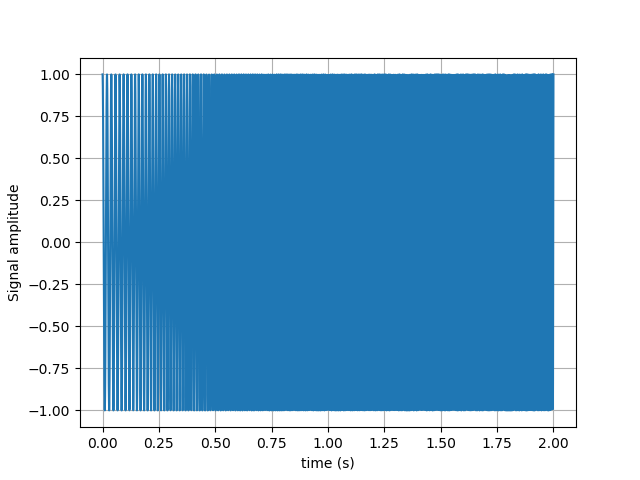

In [23]:
t, step = np.linspace(0, 2, 10000, retstep=True)
fs = 1/step
chirp_signal = chirp(t, 50, 2, 200)
plotSignal(chirp_signal, fs, t0=0, delta_t=-1)

#### Calculate spectogram

In [76]:
x = np.append(np.sin(2*np.pi*0.1*(np.arange(256))), 
              np.sin(2*np.pi*0.2*(np.arange(256))))
x = np.append(x, np.sin(2*np.pi*0.3*(np.arange(256))))
x = np.append(x, np.sin(2*np.pi*0.4*(np.arange(256))))
fs = 1
s, s_sig = timeFrequencyVisualization(x, fs, window_duration_seconds=100, 
                               window_type=None, nfft=None, window_overlap=0.5)

<IPython.core.display.Javascript object>


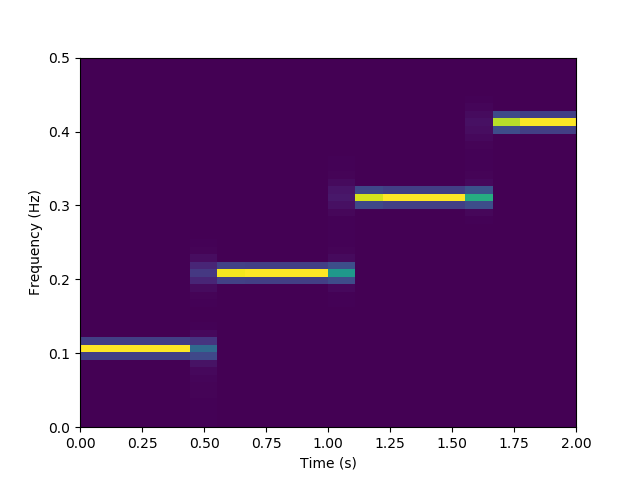

In [77]:
plot_spectogram(s, t, fs)

#### Spectogram with QMF

In [78]:
x = np.append(np.sin(2*np.pi*0.1*(np.arange(256))), 
              np.sin(2*np.pi*0.2*(np.arange(256))))
x = np.append(x, np.sin(2*np.pi*0.3*(np.arange(256))))
x = np.append(x, np.sin(2*np.pi*0.4*(np.arange(256))))
fs = 1

In [103]:
levels=4
xdc, xd = qmf_decomposition(x, h0=None, h1=None, levels=levels)
# plotSignal(xd, fs, t0=0, delta_t=-1)
vertical_scale_factor = 1
horizontal_scale_factor = 1
N = len(x)
downsample_factors = np.append(2**(levels), np.power(2, np.arange(levels, 0, -1)))
s = []
for k in range(len(xdc)):
    d = downsample_factors[k]
    x_ = xdc[k]
    x_ = x_[:int(round(N/d))]
    x_ = np.tile(x_, (int(max(downsample_factors) / d * vertical_scale_factor),1))
    x_ = np.repeat(x_, d * horizontal_scale_factor, axis=1)
    print(x_.shape)
    s = np.append(s, np.power(np.abs(x_), 2))

(1, 592)
(1, 1024)
(2, 1024)
(4, 1024)
(8, 1024)


In [95]:
t, step = np.linspace(0, (1/fs)*len(x), len(x), retstep=True)
plot_spectogram(s, t, fs)

IndexError: tuple index out of range

In [97]:
s.shape

(15952,)

#### Signal Features

In [10]:
def energy_in_bands(x, number_bands, window_duration_seconds, fs, maximum_frequency_hertz=None, num0=None, den0=None, 
                    window_type=None, maximum_order=15, iir_type='butter', filter_tol=1e-5, band_overlap_factor=0.3)
    if maximum_frequency_hertz == None:
        maximum_frequency_hertz = fs / 2
    if window_type == None
        window_type = lambda x: x
        window_type = hamming
    N_window = np.round(window_duration_seconds * fs)
    w = window_type(N_window)
    N = len(x)
    maximum_normalized_frequency = maximum_frequency_hertz / fs
    bands = [[0 : maximum_normalized_frequency / number_bands : maximum_normalized_frequency * (1 - 1/number_bands)]
    (maximum_normalized_frequency / number_bands : maximum_normalized_frequency / number_bands : maximum_normalized_frequency).' ...
    ]
    bands[1:, 0] = bands[1:, 0] - band_overlap_factor / 2 * maximum_normalized_frequency / number_bands
    bands[:len(bands)-1, 1] = bands[:len(bands)-1, 1] + band_overlap_factor/2 * maximum_normalized_frequency/number_bands;
    
'''
function [E, num, den, bands] = energy_in_bands(x, number_bands, window_duration_seconds, fs, maximum_frequency_hertz, num0, den0, window_type, maximum_order, iir_type, filter_tol, band_overlap_factor);
    if ~exist('maximum_frequency_hertz')
        maximum_frequency_hertz = fs / 2;
    end
    if ~exist('band_overlap_factor')
        band_overlap_factor = 0.3;
    end
    if ~exist('filter_tol')
        filter_tol = 1e-5;
    end
    if ~exist('iir_type')
        iir_type = @butter;
    end
    if ~exist('maximum_order')
        maximum_order = 15;
    end
    if ~exist('window_type')
        window_type = @hamming;
    end
    N_window = round(window_duration_seconds * fs);
    w = window_type(N_window);
    if size(x, 2) > size(x, 1)
        w = w.';
    end
    N = length(x);
    maximum_normalized_frequency = maximum_frequency_hertz / fs;
    bands = [...
    (0 : maximum_normalized_frequency / number_bands : maximum_normalized_frequency * (1 - 1/number_bands)).' ...
    (maximum_normalized_frequency / number_bands : maximum_normalized_frequency / number_bands : maximum_normalized_frequency).' ...
    ];
    bands(2 : end, 1) = bands(2 : end, 1) - ...
    band_overlap_factor / 2 * maximum_normalized_frequency / number_bands;
    bands(1 : end - 1, 2) = bands(1 : end - 1, 2) + ...
    band_overlap_factor / 2 * maximum_normalized_frequency / number_bands;
    if (~exist('num0')) || (~exist('den0'))
        num{number_bands} = [];
        den{number_bands} = [];
        for b = 1 : number_bands
            [num{b}, den{b}] = ...
            iir_design(iir_type, maximum_order, ...
            filter_tol, bands(b, :));
        end
    else
        num = num0;
        den = den0;
    end
    initial_n_window = 1;
    final_n_window = N_window;
    window_index = 1;
    E = zeros(ceil(N / N_window) * 2, number_bands);
    while final_n_window < N
        xwindow = (x(initial_n_window : final_n_window)) .* w;
        for b = 1 : number_bands
            x_ = filter(num{b}, den{b}, xwindow);
            E(window_index, b) = norm(x_) ^ 2;
        end
        window_index = window_index + 1;
        initial_n_window = initial_n_window + N_window;
        final_n_window = final_n_window + N_window;
    end
    E = E(1 : window_index - 1, :);
end
 
function [num, den] = iir_design(iir_type, maximum_order, filter_tol, bands);
    not_finished = 1;
    order = maximum_order;
    bands_ = bands;
    mode = 'bandpass';
    if bands(1) == 0
        bands_ = bands(2);
        mode = 'low';
    end
    if bands(2) == 0.5
        bands_ = bands(1);
        mode = 'high';
    end
    while not_finished
        [num, den] = iir_type(order, bands_ * 2, mode);
        not_finished = any(abs(roots(den)) > 1 - filter_tol);
        order = order - 1;
    end
end
'''

SyntaxError: invalid syntax (<ipython-input-10-bc948bee45ad>, line 2)

In [11]:
def featureExtraction(x, fs, window_duration_seconds, window_type=None, nfft=None, window_overlap=0.5, 
                      number_of_bands=10, maximum_frequency_hertz=None, filter_tol=1e-5, band_overlap_factor=0.3):
    N_window = int(np.round(window_duration_seconds * fs))
    if nfft == None:
        nfft = N_window
    if window_type == None:
        window_type = lambda x: x
        window_type = hamming
    w = window_type(N_window)
    window_n1 = 0
    window_n2 = window_n1 + N_window - 1
    window_shift = np.round((1-window_overlap) * N_window).astype(int)
    x_windows = np.zeros([N_window, np.floor((len(x) - N_window)/window_shift + 1).astype(int)])
    x_fft_windows = np.zeros([np.round(nfft/2).astype(int), np.floor((len(x) - N_window)/window_shift + 1).astype(int)])
    x_psd_windows = np.zeros([np.round(nfft/2).astype(int), np.floor((len(x) - N_window)/window_shift + 1).astype(int)])
    x_mean_value_ret = np.zeros(np.floor((len(x) - N_window)/window_shift + 1).astype(int))
    x_rms = np.zeros(np.floor((len(x) - N_window)/window_shift + 1).astype(int))
    x_std = np.zeros(np.floor((len(x) - N_window)/window_shift + 1).astype(int))
    x_modal_freq = np.zeros([np.floor((len(x) - N_window)/window_shift + 1).astype(int)])
    x_mean_freq = np.zeros([np.floor((len(x) - N_window)/window_shift + 1).astype(int)])
    x_median_freq = np.zeros([np.floor((len(x) - N_window)/window_shift + 1).astype(int)])
    x_energy_in_bands = np.zeros([np.floor((len(x) - N_window)/window_shift + 1).astype(int)], number_of_bands)
    number_windows = 0
    while(window_n2 <= len(x)):
        xw = x[window_n1 : window_n2+1] * w
        x_windows[:, number_windows] = xw
        x_mean_value_ret[number_windows] = np.mean(np.abs(xw))
        x_rms = np.sqrt(np.mean(np.power(xw,2)))
        x_std = np.std(xw)
        Xw = fft(xw, int(nfft))
        Xw = Xw[:int(np.floor(nfft/2))]
        x_fft_windows[:, number_windows] = Xw
        x_energy_in_bands = np.zeros(number_of_bands)
        Xw = np.power(np.abs(Xw), 2)
        x_psd_windows[:, number_windows] = Xw
        x_modal_freq[number_windows] = Xw.index(max(Xw))
        x_mean_freq[number_windows] = np.sum(Xw*linspace(0, fs/2.0, len(Xw)))/len(Xw)
        x_median_freq[number_windows] = 0
        number_windows = number_windows + 1
        window_n1 = window_n1 + window_shift
        window_n2 = window_n2 + window_shift
    return x_windows, x_mean_value_ret, x_rms, x_std, x_fft_windows, x_modal_freq, x_mean_freq, x_median_freq, x_energy_in_bands, x_psd_windows

In [ ]:
b, a = signal.iirfilter(17, [0.2, 0.3], btype='lowpass',analog=False, ftype='butter')
w, h = signal.freqs(b, a, 1000)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(w, 20 * np.log10(abs(h)))
ax.set_xscale('log')
ax.set_title('Chebyshev Type II bandpass frequency response')
ax.set_xlabel('Frequency [radians / second]')
ax.set_ylabel('Amplitude [dB]')
ax.axis((10, 1000, -100, 10))
ax.grid(which='both', axis='both')
plt.show()